In [1]:
import torch
from pyro.infer import mcmc
from pyro import distributions as dist
import numpy as np
from matplotlib import pyplot as plt
import pyro
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = "retina"

plt.style.use('ggplot')

# PyTorch Practices -- Linear Regression

Reproduce the result of PyMC3 GLM tutorial, ["GLM: Linear Regression"](https://docs.pymc.io/notebooks/GLM-linear.html), but use PyTorch and pyro mcmc kernel.

The simple linear relation:

$$
Y = \beta X + \epsilon
$$

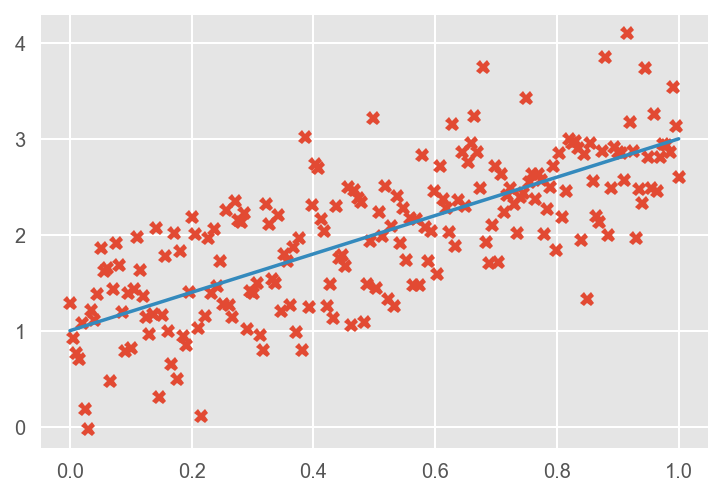

In [2]:
# generate toy dataset with linear relation
size = 200
true_intercept = 1
true_slope     = 2
x = np.linspace(0, 1, size)

# y = b x + a
true_regression_line = true_slope * x + true_intercept

# random noise with normal dist
y = true_regression_line + np.random.normal(scale=.5, size=size)

# visualize the relation
plt.plot(x, y, ls='', marker='X')
plt.plot(x, true_regression_line);

In [3]:
# convert to torch tensor
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

# Define model in pyro

Bayesian views each $Y$ as a random variable generated from 

$$
Y \sim N(X\beta, \sigma^2)
$$

We could define our priors (the same as PyMC3 tutorial)
$$
\sigma \sim \mathcal{HalfCauchy}(\beta=10, )
$$

$$
b \sim \mathcal{N}(\mu=0, \sigma=20)
$$


$$
a \sim \mathcal{N}(\mu=0, \sigma=20)
$$

In [4]:
def model(x):
    coef_intercept = pyro.sample(
        "intercept", 
        dist.Normal( torch.zeros(1), torch.ones(1) * 20 )
    )
    coef_slope     = pyro.sample(
        'slope', 
        dist.Normal( torch.zeros(1), torch.ones(1) * 20 )
    )
    sigma          = pyro.sample(
        'sigma',
        # hopefully scale in HalfCauchy means beta in PyMC3
        # since loc means the lower bound
        dist.HalfCauchy( torch.zeros(1), torch.ones(1) * 10 )
    )
    
    likelihood = pyro.sample(
        'y', 
        dist.Normal(coef_slope * x + coef_intercept, sigma),
        obs=y
    )
    
    return likelihood

# Implement MCMC kernel 

Here we chose the NUTs kernel in pyro.

In [5]:
nuts_kernel = mcmc.NUTS(model, step_size=0.00855)
mcmc_run    = mcmc.MCMC(nuts_kernel, num_samples=3000, warmup_steps=500)

posterior = {'slope' : [], 'intercept' : [], 'sigma' : []}

for trace, _ in mcmc_run._traces(x):
    posterior['slope'].append(trace.nodes['slope']['value'].numpy())
    posterior['intercept'].append(trace.nodes['intercept']['value'].numpy())
    posterior['sigma'].append(trace.nodes['sigma']['value'].numpy())

# Plot the posterior and trace

In [6]:
# to numpy array 
for key in posterior.keys():
    posterior[key] = np.array(posterior[key])

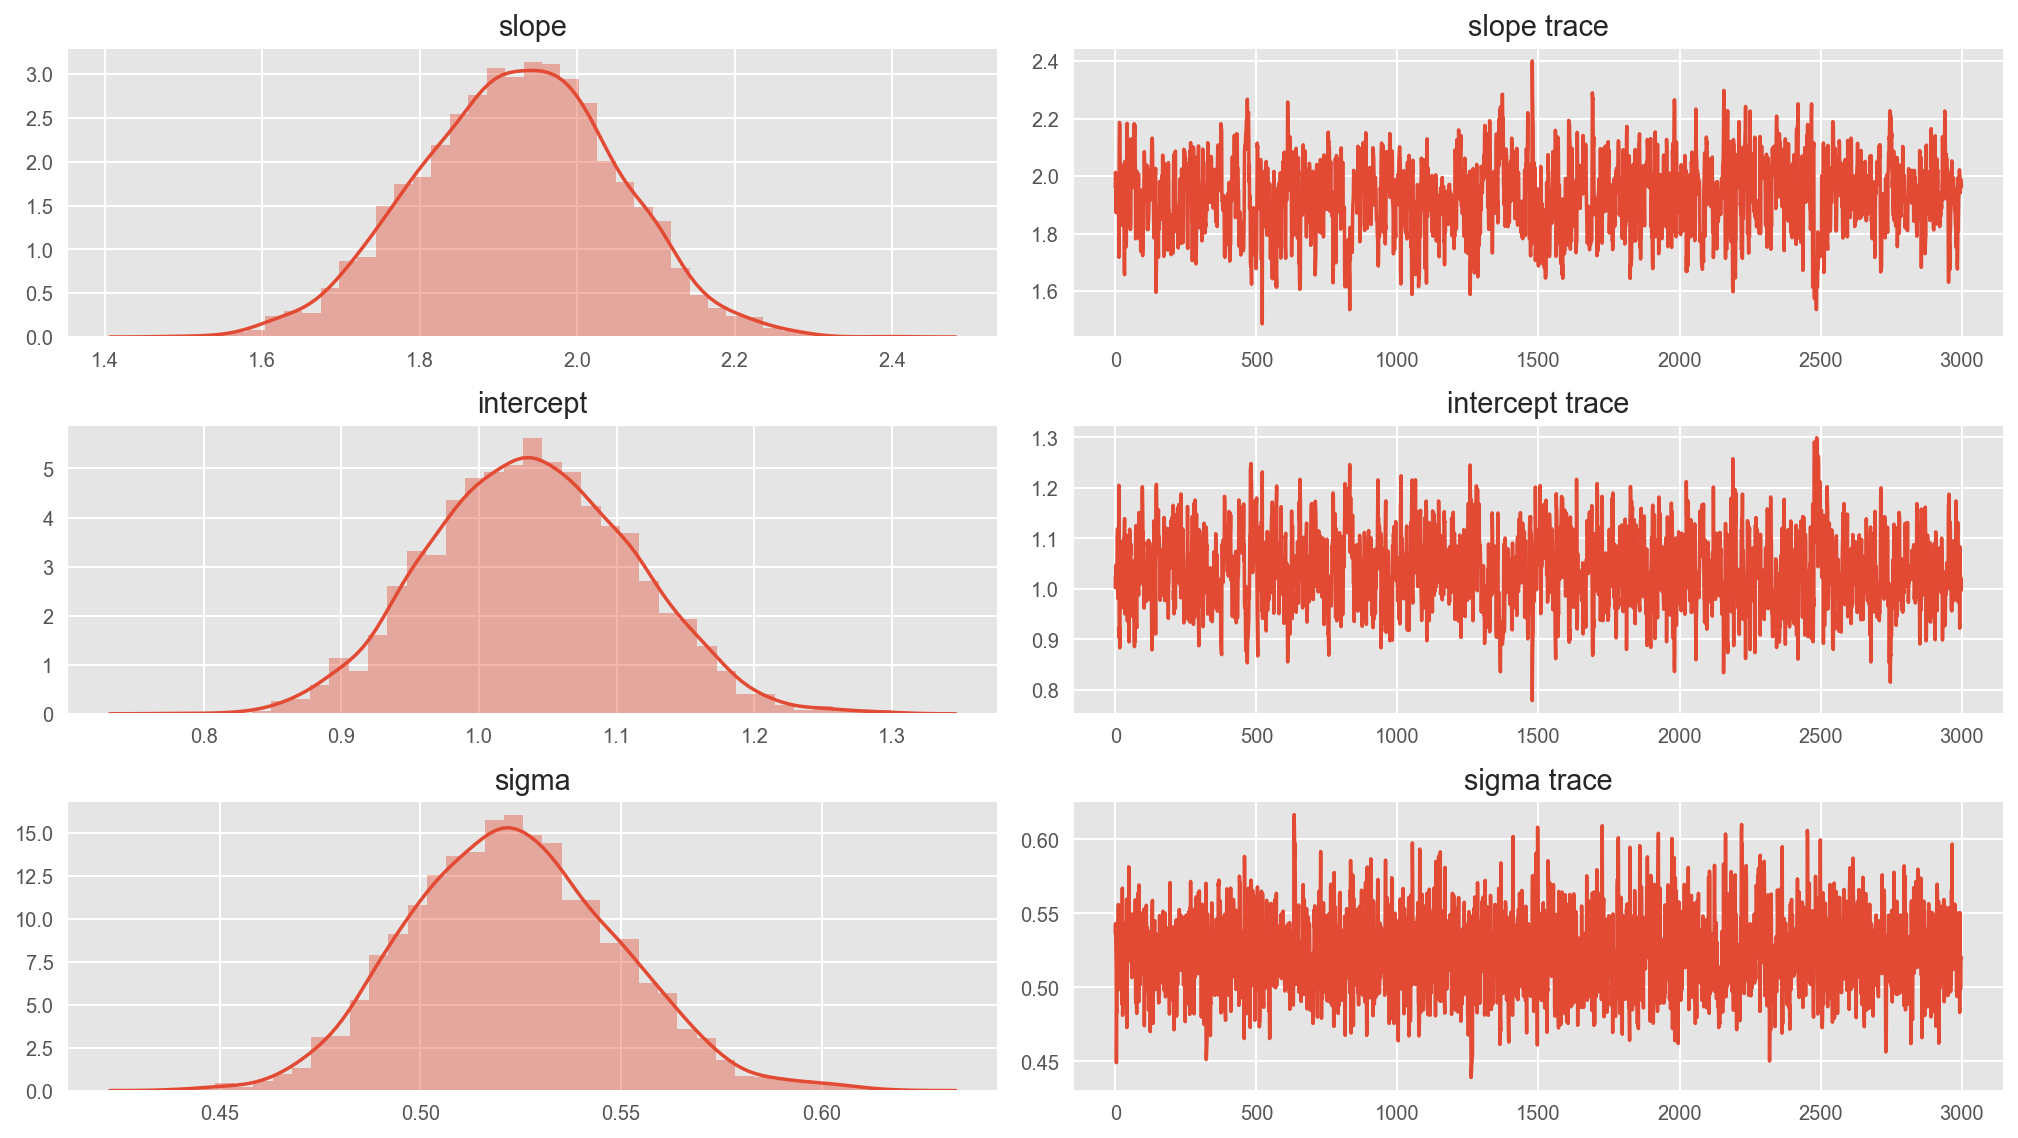

In [7]:
def posterior_plot(posterior):
    fig, ax = plt.subplots(len(posterior), 2, figsize=(14, 8))
    
    for i,key in enumerate(posterior.keys()):
        sns.distplot(posterior[key], ax=ax[i, 0],)
        ax[i, 0].set_title(key)
        ax[i, 1].plot(posterior[key], )
        ax[i, 1].set_title(key + ' trace')
    plt.tight_layout()
    
    
posterior_plot(posterior)    

# Plot posterior in x-y plot

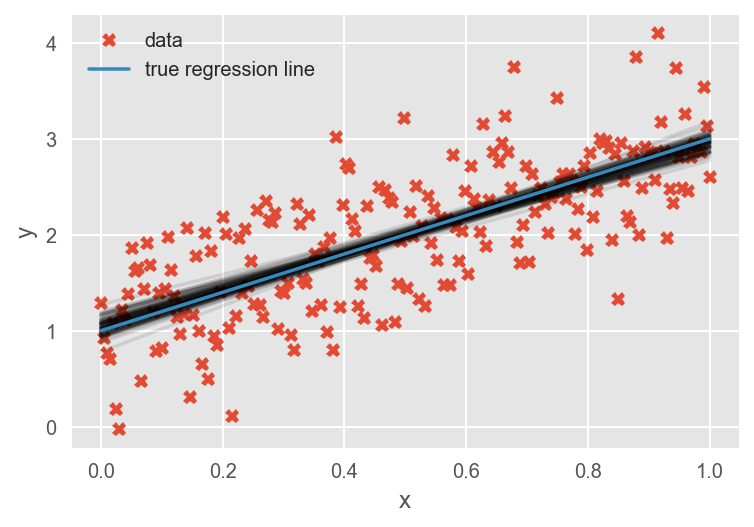

In [8]:
y_posterior = posterior['slope'] * x.numpy() + posterior['intercept']

# sampling 
sampling = np.random.randint(0, 3000, size=100)

plt.plot(x.numpy(), y.numpy(), ls='', marker='X', label='data')    
for y_pred in y_posterior[sampling]:
    plt.plot(x.numpy(), y_pred, c='k', alpha=0.1)
    
plt.plot(x.numpy(), true_regression_line, label='true regression line')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')